# Spam classification with naive Bayes

Consider the spam classification problem in [Spam classification using logistic regression](https://nbviewer.jupyter.org/github/ppham27/MLaPP-solutions/blob/master/chap08/1.ipynb).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from classifiers import read_spam_data, transform_log, transform_binary

train_data, test_data = read_spam_data()

# transform the data
ytrain = train_data['spam'].as_matrix()
ytest = test_data['spam'].as_matrix()
Xtrain_raw = train_data.drop('spam', axis = 1).as_matrix()
Xtest_raw = test_data.drop('spam', axis = 1).as_matrix()
Xtrain_standard = preprocessing.scale(Xtrain_raw, axis=0)
Xtest_standard = preprocessing.scale(Xtest_raw, axis=0)
Xtrain_log = np.apply_along_axis(transform_log, axis = 0, arr=Xtrain_raw)
Xtest_log = np.apply_along_axis(transform_log, axis = 0, arr=Xtest_raw)
Xtrain_binary = np.apply_along_axis(transform_binary, axis = 0, arr=Xtrain_raw)
Xtest_binary = np.apply_along_axis(transform_binary, axis = 0, arr=Xtest_raw)

data_transform = ['Raw', 'Standard', 'Log', 'Binary']
Xtrain = [Xtrain_raw, Xtrain_standard, Xtrain_log, Xtrain_binary]
Xtest = [Xtest_raw, Xtest_standard, Xtest_log, Xtest_binary]

test_data.head()

,spam,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0
1,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0
2,1,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,...,0.0,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445.0,1257.0
3,1,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,...,0.0,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43.0,749.0
4,1,0.00,0.69,0.34,0.0,0.34,0.00,0.00,0.00,0.00,...,0.0,0.00,0.056,0.0,0.786,0.000,0.000,3.728,61.0,261.0


Let us try classifying with naive Bayes instead. 

Logistic regression is a discriminative model since we try to learn the conditional distribution $p(y \mid \mathbf{x})$, whereas, naive Bayes is a generative model since we try to learn the joint distribution $p(\mathbf{x}, y).$ 

Suppose that $\mathbf{x} = \left(x_1,x_2,\ldots,x_p\right)^\intercal$. Then, the joint distribution can be factored as

\begin{equation}
p(\mathbf{x}, y) = p(y)p(x_1 \mid y)p(x_2 \mid x_1, y)
\cdots p(x_p \mid x_1,x_2,\ldots,x_{p-1} ,y).
\end{equation}

It's not hard to see that this quickly becomes unfeasible both due to lack of data and memory constraints. If each $x_i$ can take on even two values, then we have on the order of $O(2^p)$ parameters. 

Naive Bayes makes the simplifying assumption that the elements of $\mathbf{x}$ are conditionally independent given $y$, so we can write

\begin{equation}
p(\mathbf{x}, y) = p(y)p(x_1 \mid y)p(x_2 \mid y)
\cdots p(x_p \mid y) = p(y)p(\mathbf{x} \mid y),
\end{equation}

so now we merely have $O(pK)$ parameters, where $p$ is the number of features and $K$ is the number of classes.

Once we have figured out the joint distribution, finding the conditional distribution is easy. It's just

\begin{equation}
p(y = k \mid \mathbf{x}) = \frac{p(\mathbf{x}, y = k)}{\sum_{k^\prime=1}^Kp(\mathbf{x}, y = k^\prime)}.
\end{equation}

The various flavors of naive Bayes mainly differ on the distribution for $p(\mathbf{x} \mid y)$.


## Bernoulli naive Bayes

As one can probably guess from its name, the assumption is that

\begin{equation}
x_{j} \mid y = k \sim \operatorname{Bernoulli}(\theta_{jk}).
\end{equation}

We also assume that 

\begin{equation}
y \sim \operatorname{Multinomial}(1, \boldsymbol{\pi}), 
~\text{where}~\boldsymbol\pi = (\pi_1,\pi_2,\ldots,\pi_K)
~\text{and}~\sum_{k = 1}^K \pi_k = 1.
\end{equation}

How should we estimate $\boldsymbol\theta$ and $\boldsymbol\pi$? One option is to put a prior on each $\theta_{jk}$ and $\boldsymbol\pi$. If we do this, we have that

\begin{align}
p(\mathbf{x}, y = k) &= 
\int\int p(\mathbf{x}, y = k \mid \boldsymbol\theta, \boldsymbol\pi)p(\boldsymbol\theta, \boldsymbol\pi)\,d\boldsymbol\pi\,d\boldsymbol\theta = 
\int p(y=k \mid \boldsymbol\pi)p(\boldsymbol\pi)\,d\boldsymbol\pi 
\int p(\mathbf{x} \mid \boldsymbol \theta)\,d\boldsymbol\theta \\
&= \int p(y=k \mid \boldsymbol\pi)p(\boldsymbol\pi)\,d\boldsymbol\pi
   \int p(x_1 \mid y = k, \theta_{1k})p(\theta_{1k})\,d\theta_{1k}
   \int p(x_2 \mid y = k, \theta_{2k})p(\theta_{2k})\,d\theta_{2k}
   \cdots
   \int p(x_p \mid y = k, \theta_{pk})p(\theta_{2k})\,d\theta_{pk}
\end{align}

if we make all the priors independent of each other. Now, the integration becomes simple if we use conjugate priors. We let $\theta_{jk} \sim \operatorname{Beta}(\alpha_{jk}, \beta_{jk})$ and $\boldsymbol\pi \sim \operatorname{Dirichlet}(\boldsymbol\gamma)$.

Now consider conditioning on the data $\mathcal{D}$, too. Say make $N$ observations in total, and we observe $N_k$ instances of each class $k$. Morever, we observe $N_{kj}$ instances of a feature $j$ in class $k$.

We will have that

\begin{align}
\int p(y=k \mid \boldsymbol\pi, \mathcal{D})p(\boldsymbol\pi \mid \mathcal{D})\,d\boldsymbol\pi &= \frac{N_k + \gamma_k}{N + \sum_{k^\prime = 1}^K \gamma_{k^\prime}} \\
\int p(x_j  = 1\mid y = k, \theta_{jk}, \mathcal{D})p(\theta_{jk} \mid \mathcal{D})\,d\theta_{jk} 
&= \frac{N_{kj} + \alpha_{jk}}{N_k + \alpha_{jk} + \beta_{jk}}
\end{align}
by [Table_of_conjugate_distributions](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

In this manner, we have that

\begin{equation}
\log p(\mathbf{x}, y = k \mid \mathcal{D}) = 
\log\left(\frac{N_k + \gamma_k}{N + \sum_{k^\prime = 1}^K \gamma_{k^\prime}} \right)
+ \sum_{j=1}^p \left(
x_j\log\left(\frac{N_{kj} + \alpha_{jk}}{N_k + \alpha_{jk} + \beta_{jk}}\right)
+
(1 - x_j)\log\left(\frac{N_k - N_{kj} + \beta_{jk}}{N_k + \alpha_{jk} + \beta_{jk}}\right)
\right),
\end{equation}
where we compute the log sum for numerical stability. In practice, we often let $\alpha_{jk} = \beta_{jk}$ and $\alpha_{jk} = \alpha_{j^\prime k^\prime}$ for all $j$, $j^\prime$, $k$, and $k^\prime$.

Let's try this model out.

In [2]:
# from sklearn.naive_bayes import BernoulliNB # reference sklearn implementation
from classifiers import BernoulliNB

# bernNBClf = BernoulliNB(alpha = 1, fit_prior = True)
bernNBClf = BernoulliNB(alpha = 1)
bernNBClf.fit(Xtrain_binary, ytrain)
print(1 - bernNBClf.score(Xtest_binary, ytest))

0.110026041667


We find that we achieve a misclassification rate of 11% with Laplace smoothing ($\alpha = 1$). You can see the my implementation of naive Bayes on [GitHub](https://github.com/ppham27/MLaPP-solutions/blob/master/chap08/classifiers.py). Let us try to pick the correct value of $\alpha$.

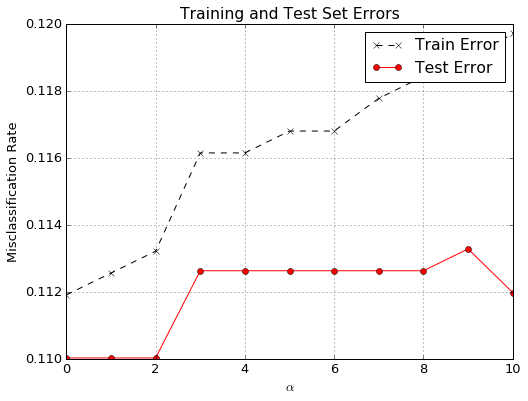

In [3]:
binary_misclassification_rate = pd.DataFrame(index=np.arange(11), 
                                             columns=["Train Error", "Test Error"], 
                                             dtype=np.float64)
for alpha in binary_misclassification_rate.index:
    bernNBClf = BernoulliNB(alpha = alpha)
    bernNBClf.fit(Xtrain_binary, ytrain)
    binary_misclassification_rate.loc[alpha]['Train Error'] = 1 - bernNBClf.score(Xtrain_binary, ytrain)
    binary_misclassification_rate.loc[alpha]['Test Error'] = 1 - bernNBClf.score(Xtest_binary, ytest)
## let us plot these results
plt.rc('font', size=13.)
plt.figure(figsize=(8, 6))
plt.plot(binary_misclassification_rate.index, 
         binary_misclassification_rate['Train Error'], '--xk',
         binary_misclassification_rate['Test Error'], '-or')
plt.legend(labels = binary_misclassification_rate.columns)
plt.xlabel(r"$\alpha$")
plt.ylabel("Misclassification Rate")
plt.title("Training and Test Set Errors")
plt.grid(True)
plt.show()

So, a value of $\alpha = 1$ does achieve the lowest misclassification rate. Of course, this flavor of naive Bayes only worked on binary features. Let us extend this method by assuming a different distribution for $p(\mathbf{x} \mid y)$.

## Gaussian naive Bayes

Now, we assume that 

\begin{equation}
x_j \mid y = k \sim \mathcal{N}(\mu_{jk}, \sigma^2_{jk}).
\end{equation}

One can see that this is equivalent to writing

\begin{equation}
\mathbf{x} \mid y = k \sim \mathcal{N}(\boldsymbol\mu_{k}, \Sigma_{k}),
\end{equation}

where $\Sigma$ is a diagonal matrix, so this is equivalent to [Quadratic Discriminant Analysis](https://nbviewer.jupyter.org/github/ppham27/MLaPP-solutions/blob/master/chap04/17.ipynb) restricted to diagonal matrices.

There's not really a reasonable prior to use, so we can esimate the parameters wit maximum likelihood esimate (MLE). We have that

\begin{align}
\hat{\mu}_{jk} &= \frac{1}{N_k}\sum_{\{i~:~y_i = k\}} x_{ij} \\
\hat{\sigma}^2_{jk} &= \frac{1}{N_k}\sum_{\{i~:~y_i = k\}}\left(x_{ij} - \hat{\mu}_{jk}\right)^2 
= \frac{1}{N_k}\sum_{\{i~:~y_i = k\}}x_{ij}^2 - \hat{\mu}_{jk}^2,
\end{align}

so we just need to keep track of the class counts and the sums and squared sums for each feature and class. 

We still give $y$ a multinomial distribution, so we can put the same Dirichlet distribution on $\boldsymbol\pi$.

In [4]:
## from sklearn.naive_bayes import GaussianNB # reference sklearn implementation
from classifiers import GaussianNB

gaussNBClf = GaussianNB()
gaussNBClf.fit(Xtrain_log, ytrain)
1 - gaussNBClf.score(Xtest_log, ytest)

0.18098958333333337

You can see my code for Gaussian naive Bayes on [GitHub](https://github.com/ppham27/MLaPP-solutions/blob/master/chap08/classifiers.py), too. Let's compare all the error rates for the various methods and data transforms.

In [5]:
misclassification_rates = pd.DataFrame(index=data_transform, 
                                       columns=['Train Error', 'Test Error'],
                                       dtype=np.float64)
misclassification_rates.loc['Binary'] = binary_misclassification_rate.iloc[np.argmin(binary_misclassification_rate['Test Error'])]
for i in range(len(data_transform)):
    if data_transform[i] != 'Binary':
        gaussNBClf = GaussianNB()
        gaussNBClf.fit(Xtrain[i], ytrain)
        misclassification_rates.loc[data_transform[i]]['Train Error'] = 1 - gaussNBClf.score(Xtrain[i], ytrain)
        misclassification_rates.loc[data_transform[i]]['Test Error'] = 1 - gaussNBClf.score(Xtest[i], ytest)
misclassification_rates.head()

,Train Error,Test Error
Raw,0.175856,0.185547
Standard,0.175856,0.188802
Log,0.163458,0.180990
Binary,0.111909,0.110026


Just as before in [Spam classification using logistic regression](https://nbviewer.jupyter.org/github/ppham27/MLaPP-solutions/blob/master/chap08/1.ipynb), the log transform gives us the lowest misclassification rate for continuous data. Binary is best overall, however. Now, just for fun, let's plot these differences since I need to learn how to make bar graphs with `matplotlib`.

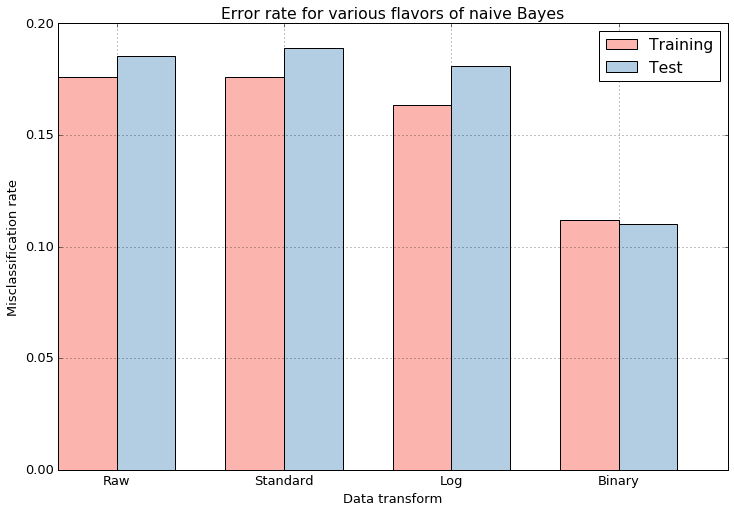

In [6]:
bar_width = 0.35
plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(misclassification_rates)),
        misclassification_rates['Train Error'],
        bar_width, color='#fbb4ae', label="Training")
plt.bar(np.arange(len(misclassification_rates)) + bar_width,
        misclassification_rates['Test Error'],
        bar_width, color='#b3cde3', label="Test")

plt.legend()
plt.xlabel("Data transform")
plt.ylabel("Misclassification rate")
plt.title("Error rate for various flavors of naive Bayes")
plt.xticks(np.arange(len(misclassification_rates)) + bar_width, misclassification_rates.index)
plt.grid(True)
plt.show()

Clearly, logistic regression works much better, for in [Spam classification using logistic regression](https://nbviewer.jupyter.org/github/ppham27/MLaPP-solutions/blob/master/chap08/1.ipynb), we achieve an error rate of 5.8% compared to 11% here. Amazingly, logistic regression has much fewer parameters, too. For logistic regression, we have a coefficient for each feature plus an intercept term, which gives a mere $p + 1$ parameters. On the other hand, naive Bayes has at least 1 parameter for each feature-class combination, which gives us at least $pK$ parameters. Despite this disparity, logistic regression outperforms naive Bayes. 

For whatever reason, naive Bayes works better with discrete features versus continuous features for this particular problem. I wonder if a mixed model using both continuous and discrete features would work better?